In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import numpy as np
from scipy.sparse.linalg import cg, lsqr
import matplotlib.pyplot as plt
import matplotlib.tri
import okada_wrapper
import tectosaur as tct

In [62]:
TCTN = 61
CURVE = 1.0

corners = [[-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, 0, 1]]
src_mesh = tct.make_rect(TCTN, TCTN, corners)
src_mesh[0][:,1] = CURVE * np.abs(src_mesh[0][:,0])
#src_mesh[0][:,1] = CURVE * (src_mesh[0][:,0] ** 2 + src_mesh[0][:,2] ** 2)
def gauss_slip_fnc(x, z):
    r2 = x ** 2 + z ** 2
    R = 0.5
    out = (np.cos(np.sqrt(r2) * np.pi / R) + 1) / 2.0
    out[np.sqrt(r2) > R] = 0.0
    return out
dof_pts = src_mesh[0][src_mesh[1]]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((src_mesh[1].shape[0], 3, 3)).astype(np.float32)
slip[:,:,0] = gauss_slip_fnc(x, z)

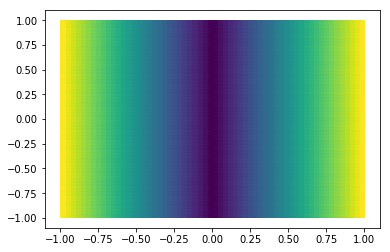

In [63]:
plt.tripcolor(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1], src_mesh[0][:,1])
plt.show()

In [64]:
H = tct.RegularizedSparseIntegralOp(
    6, 6, 6, 2, 5, 2.5,
    'elasticRH3', 'elasticRH3', [1.0, 0.25], src_mesh[0], src_mesh[1], np.float32,
    farfield_op_type = tct.TriToTriDirectFarfieldOp
)
traction_mass_op = tct.MassOp(4, src_mesh[0], src_mesh[1])

[3079887:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[3079891:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[3079893:DEBUG:tectosaur.nearfield.nearfield_op]
         setup pairs integrator took 0.006155394017696381
[3080092:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident took 0.197934128344059
[3080095:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident correction took 0.002511821687221527
[3080252:DEBUG:tectosaur.nearfield.nearfield_op]
         Find nearfield/adjacency took 0.15543672069907188
[3080375:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent took 0.12181037291884422
[3080380:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent correction took 0.004305381327867508
[3080541:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent took 0.1602952852845192
[3080552:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent correction took 0.009771399199962616
[3080802:DEBUG:tec

In [65]:
dof_pts = src_mesh[0][src_mesh[1]]
from tectosaur.util.geometry import unscaled_normals
ns = unscaled_normals(dof_pts)
ns /= np.linalg.norm(ns, axis = 1)[:, np.newaxis]
ns = np.repeat(ns, 3, axis = 0)

edge_dofs = tct.free_edge_dofs(src_mesh[1], tct.find_free_edges(src_mesh[1]))

obs_pts = dof_pts.reshape((-1,3))[edge_dofs]
obs_ns = ns[edge_dofs]
interior_op = tct.InteriorOp(obs_pts.copy(), obs_ns.copy(), src_mesh, 'elasticH3', 4.0, 10, 6, 6, [1.0, 0.25], np.float32)

trac_edges = -interior_op.dot(slip.flatten())

vec_edge_dofs = np.tile(3 * np.array(edge_dofs)[:,np.newaxis], (1,3))
vec_edge_dofs[:,1] += 1
vec_edge_dofs[:,2] += 2
vec_edge_dofs = vec_edge_dofs.flatten()
edge_cs = tct.simple_constraints(vec_edge_dofs, trac_edges)

[3081189:DEBUG:tectosaur.util.gpu]
    returning cached gpu module matrix_free.cl
[3081192:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[3081220:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[3081279:DEBUG:tectosaur.util.gpu]
    start compiling interior_corners.cl
[3082210:DEBUG:tectosaur.util.gpu]
     compile took 0.9308673404157162


In [66]:
cs = tct.continuity_constraints(src_mesh[0], src_mesh[1], src_mesh[1].shape[0])
cs.extend(edge_cs)
cmU, _, _ = tct.build_constraint_matrix(cs, src_mesh[1].shape[0] * 9)

In [ ]:
csT1, csT2 = tct.traction_admissibility_constraints(src_mesh[0], src_mesh[1], slip, 1.0, 0.25)
csT1.extend(edge_cs)
cmT, c_rhs, _ = tct.build_constraint_matrix(csT1, src_mesh[1].shape[0] * 9)

import scipy.sparse
rows = []
cols = []
data = []
for i in range(len(csT2)):
    c = csT2[i]
    for j in range(len(c.terms)):
        rows.append(i)
        cols.append(c.terms[j].dof)
        data.append(c.terms[j].val)
cmT2 = scipy.sparse.csr_matrix((data, (rows, cols)), shape = (len(csT2), cmT.shape[0]))

constrained_traction_mass_op = cmU.T.dot(traction_mass_op.mat.dot(cmT))
full_lhs = scipy.sparse.vstack((constrained_traction_mass_op, cmT2.dot(cmT)))
rhs = -cmU.T.dot(H.dot(slip.flatten())) - cmU.T.dot(traction_mass_op.mat.dot(c_rhs))
full_rhs = np.concatenate((rhs, np.zeros(cmT2.shape[0])))

# full_lhs.shape, full_rhs.shape, cmT.shape, cmU.shape, cmT2.shape, constrained_traction_mass_op.shape

#soln = cg(constrained_traction_mass_op, rhs)
soln = lsqr(full_lhs, full_rhs)
out = cmT.dot(soln[0]) + c_rhs

pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,2] - 0.1) < 0.01)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.figure(figsize = (18, 6))
for d in range(3):
    plt.subplot(1,3,d+1)
    plt.plot(pts[idxs][:,0], out.reshape((-1,3))[idxs][:,d], '-*')
plt.show()
    
pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,0]) < 0.02)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.figure(figsize = (18, 6))
for d in range(3):
    plt.subplot(1,3,d+1)
    plt.plot(pts[idxs][:,2], out.reshape((-1,3))[idxs][:,d], '.')
plt.show()

def plotter(fields):
    levels = []
    for f in fields:
        minf = np.min(f)
        maxf = np.max(f)
        levels.append(np.linspace(minf - 1e-12, maxf + 1e-12, 21))
    #levels[2] = np.linspace(-0.15, 0.15, 11)
    # levels = [
    #     np.linspace(-0.1, 0.6, 21),
    #     np.linspace(-1.9, 1.9, 21),
    #     np.linspace(-0.2, 0.2, 21)
    # ]
    tri_centers = np.mean(src_mesh[0][src_mesh[1]], axis = 1)
    side = np.zeros(src_mesh[1].shape[0]).astype(np.int)
    side[tri_centers[:,0] > 0] = 1
    n_sides = 2

    cmap = 'RdBu_r'
    plt.figure(figsize = (16, 6))
    for d in range(len(fields)):
        plt.subplot(1,len(fields),d+1)
        field = fields[d]
        for i in range(n_sides):
            which_tris = np.where(side == i)[0]
            reduced_m = tct.mesh.modify.remove_unused_pts((src_mesh[0], src_mesh[1][which_tris]))
            soln_vals = np.empty(reduced_m[0].shape[0])
            soln_vals[reduced_m[1]] = field[which_tris]
            cntf = plt.tricontourf(
                reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
                cmap = cmap, linewidth = 0.5, levels = levels[d], extend = 'both'
            )
            plt.tricontour(
                reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
                linestyles = 'solid', colors='k', linewidths = 0.7, levels = levels[d]
            ) 
        plt.colorbar(cntf)
        plt.tight_layout()
    plt.show()
    
zvec = np.cross(ns, [0,1,0])
xvec = np.cross(zvec, ns)

normal_trac = np.sum(out.reshape((-1,3)) * ns, axis = 1).reshape((-1,3))
horizontal_shear = np.sum(out.reshape((-1,3)) * xvec, axis = 1).reshape((-1,3))
vertical_shear = np.sum(out.reshape((-1,3)) * zvec, axis = 1).reshape((-1,3))
    
plotter([
    horizontal_shear, 
    normal_trac,
    vertical_shear
])
plotter([
    out.reshape((-1,3,3))[:,:,d]
    for d in range(3)
])

> /home/tthompson/Dropbox/projects/tectosaur/tectosaur/tectosaur/continuity.py(222)strain_invariant()
    220     Tracer()()
    221 
--> 222     return I1, L, s12
    223 
    224 def traction_admissibility_constraints(pts, tris, disp, sm, pr):



ipdb>  s11


array([ 0.        , -0.23570226,  0.23570226,  0.        ])


ipdb>  s22


array([ 0.        , -0.23570226,  0.23570226,  0.        ])


ipdb>  s33


array([ 0.        , -0.70710678,  0.70710678,  0.        ])


ipdb>  e11


array([0., 0., 0., 0.])


ipdb>  e22


array([0., 0., 0., 0.])


ipdb>  e33


array([-0.        , -0.23570226,  0.23570226,  0.        ])


ipdb>  s12


array([0., 0., 0., 0.])


ipdb>  s23


array([0., 0., 0., 1.])


ipdb>  s13


array([ 0.        , -0.70710678, -0.70710678,  0.        ])


ipdb>  s33


array([ 0.        , -0.70710678,  0.70710678,  0.        ])


ipdb>  s33 + s13 + s23


array([ 0.00000000e+00, -1.41421356e+00, -1.11022302e-16,  1.00000000e+00])
